#  Regularizing Neural Networks 

* Neural networks learn a set of weights that best map inputs to outputs.
* Deep learning neural networks are likely to quickly overfit a training dataset with few examples.

## Weight penalties

* A network with large network weights can be a sign of an unstable network where small changes in the input can lead to large changes in the output. This can be a sign that the network has overfit the training dataset and will likely perform poorly when making predictions on new data.
* A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called weight regularization and it can be used as a general technique to reduce overfitting of the training dataset and improve the generalization of the model.
* We will mainly explore L1 regularization and L2 regularization.

### L1 norm and L2 norm

* Before delving into L1/L2 regularization, let's spend a bit of time introducing L1/L2 norm.
* In mathematics, a "norm" is a function from vector space to the non-negative real numbers that behaves in certain ways "like the distance from the origin".
* L1 norm:

$$
\left\lVert x \right\rVert_1 = \sum_{i=1}^n \left| x_i \right|
$$

* L2 norm:

$$
\left\lVert x \right\rVert_2 = \sqrt{\sum_{i=1}^n x_i^2}
$$

* Function graph (one of the interesting differences is how their derivatives change when $w$ changes):

<img src="./assets/regularization/l1-and-l2-norms.gif" alt="L1 and L2 norms" style="width: 500px;"/>

### L1 regularization

* The formula for MSE with L1 regularization is:

$$
MSE_{L1} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}i)^2 + \lambda \sum_{j=1}^{p}(|w_j|)
$$

* where:

    * $n$ is the number of samples in the dataset
    * $y_i$ is the true target value for the $i$-th sample
    * $\hat{y}_i$ is the predicted target value for the $i$-th sample
    * $p$ is the number of weights in the dataset
    * $w_j$ is the coefficient of the $j$-th weight in the model
    * $\lambda$ is the regularization parameter, which controls the strength of the L1 regularization penalty

* The general idea is that apart from minimizing the loss function, we also want to penalize the L1 "distance" from the weight vector to origin.
* Let's have a toy project that demonstrates this!
  * It seems that neural network is less prone to overfitting than traditional models such as Random Forest, but given the nature of this note, let's use neural network anyways... 

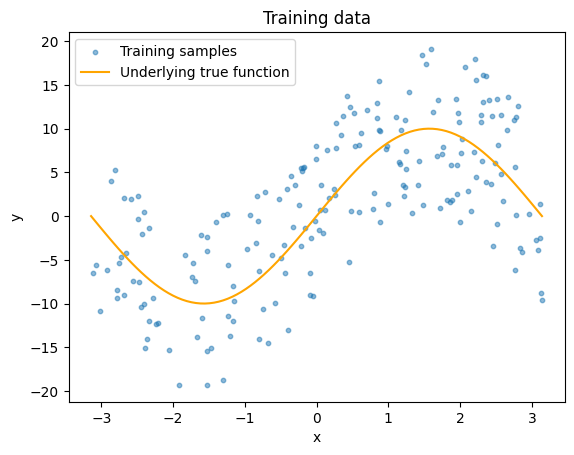

In [75]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

# So that we can reproduce the same result
random.seed(1080)
np.random.seed(1024)
tf.random.set_seed(168)

amplitude = 10.0
X = np.random.uniform(-np.pi, np.pi, size=(400, 1))
y = np.sin(X) * amplitude
noise = np.random.uniform(low=-amplitude,high=amplitude, size=y.shape)
y += noise
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=8)

# Generate a grid of x values for plotting the true function
x_plot = np.linspace(-np.pi, np.pi, num=100)
y_plot = np.sin(x_plot) * amplitude

# Plot the data
plt.scatter(x_train, y_train, s=10, alpha=0.5, label="Training samples")
plt.plot(x_plot, y_plot, color='orange', label='Underlying true function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data')
plt.legend()
plt.show()

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def lr_scheduler(epoch: int, lr: float) -> float:
    if epoch < 20:
        return lr
    else:
        return lr * 0.95

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])

λ = 2e-5
model_reg = keras.Sequential([
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(λ)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(λ)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(λ)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(λ)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1(λ)),
    layers.Dense(1)
])

loss_fn = keras.losses.MeanSquaredError()

lr = 5e-2
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])
model_reg.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])

epochs = 100
model.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)
model_reg.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)

7/7 [==============================] - 0s 3ms/step


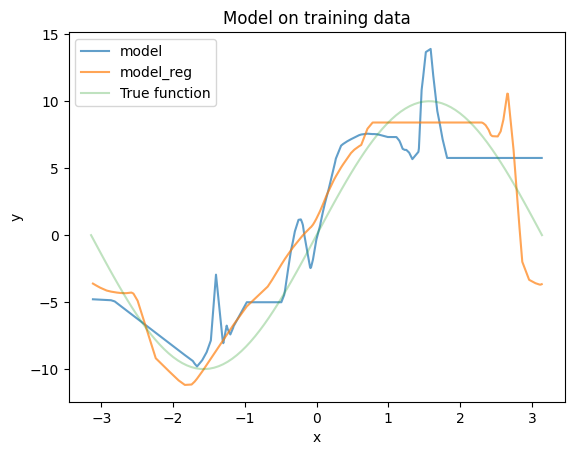

In [77]:
x_sorted, y_sorted = zip(*sorted(zip(x_train, model.predict(x_train))))
plt.plot(x_sorted, y_sorted, alpha=0.7, label='model')
x_sorted, y_sorted = zip(*sorted(zip(x_train, model_reg.predict(x_train))))
plt.plot(x_sorted, y_sorted, alpha=0.7, label='model_reg')
plt.plot(x_plot, y_plot, alpha=0.3, label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model on training data')
plt.legend()
plt.show()

7/7 [==============================] - 0s 3ms/step


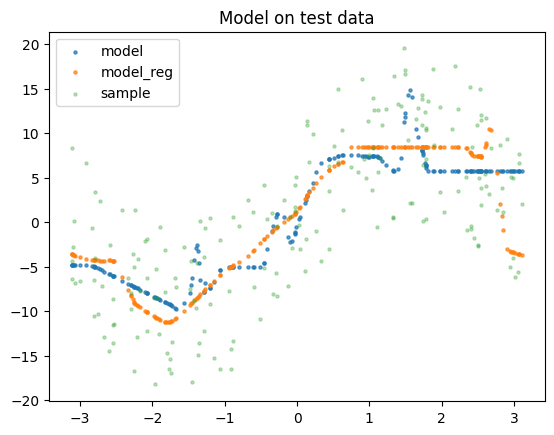

tf.Tensor(35.29254, shape=(), dtype=float32)
tf.Tensor(33.819008, shape=(), dtype=float32)


In [78]:
y_pred = model.predict(x_test)
y_pred_reg = model_reg.predict(x_test)

plt.scatter(x_test, y_pred, s=5, alpha=0.7, label='model')
plt.scatter(x_test, y_pred_reg, s=5, alpha=0.7, label='model_reg')
plt.scatter(x_test, y_test, s=5, alpha=0.3, label='sample')
plt.title('Model on test data')
plt.legend()
plt.show()

mse = keras.losses.MeanSquaredError()
print(mse(y_test, y_pred))
print(mse(y_test, y_pred_reg))

## Dropout

* Ensembles of neural networks (i.e., a large number of neural networks) with different model configurations are known to reduce overfitting, but require the additional computational expense of training and maintaining multiple models.
* A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during **training**.
* Dropout is implemented per-layer in a neural network. It can be used with most types of layers, such as dense fully connected layers, convolutional layers, and recurrent layers such as the long short-term memory network layer.
* Dropout can be used after convolutional layers (e.g. Conv2D) and after pooling layers (e.g. MaxPooling2D).

## References
* [Use Weight Regularization to Reduce Overfitting of Deep Learning Models](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/)
* [A Gentle Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
* [How to Reduce Overfitting With Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)
* [How to Reduce Overfitting Using Weight Constraints in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-neural-networks-with-weight-constraints-in-keras/)